# Evaluation on synthetic data

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from mlreflect.curve_fitter import CurveFitter
from mlreflect.data_generation import ReflectivityGenerator, interp_reflectivity
from mlreflect.models import DefaultTrainedModel, TrainedModel
from mlreflect.training import InputPreprocessor, OutputPreprocessor
from tensorflow import keras

from lib import (
    config,
    data_gen,
    evaluation_functions,
    global_,
    metrics,
    pipeline,
    plots,
)

np.random.seed(224)
NUMBER_OF_CURVES = 10240


In [2]:
NOISE_LEVEL = 0.3
MODEL_PATH = "models3l/0.3_25_50_75_12_8_4_256_20220812-145510"
BATCH_SIZE = 256


__Generate model object__

In [3]:
model_object = config.ModelLoader(model_path=MODEL_PATH, noise_level=NOISE_LEVEL)


__Generate data dictionary__

In [4]:
data_dict = evaluation_functions.simulate_and_predict(
    global_.Q_VALUES, NUMBER_OF_CURVES, BATCH_SIZE, model_object
)


100%|██████████| 10240/10240 [00:00<00:00, 13456.60it/s]


__Calculate errors__

In [5]:
error_dict_mse_error = metrics.get_mse(data_dict, model_object)


In [6]:
error_dict_log_error = metrics.get_log_error(data_dict)


In [7]:
error_dict_absolute_error = metrics.get_absolute_error(data_dict)


In [8]:
error_dict_relative_error = metrics.get_relative_error(
    error_dict_absolute_error, data_dict
)


__Make plots__

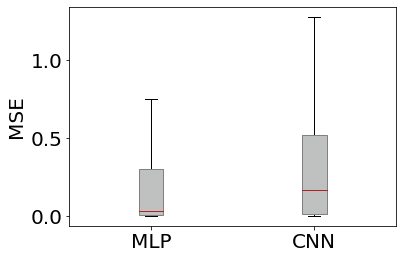

In [9]:
plots.gen_mse_plots(error_dict_mse_error)


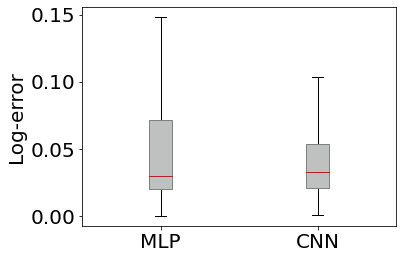

In [10]:
plots.gen_log_plots(error_dict_log_error)


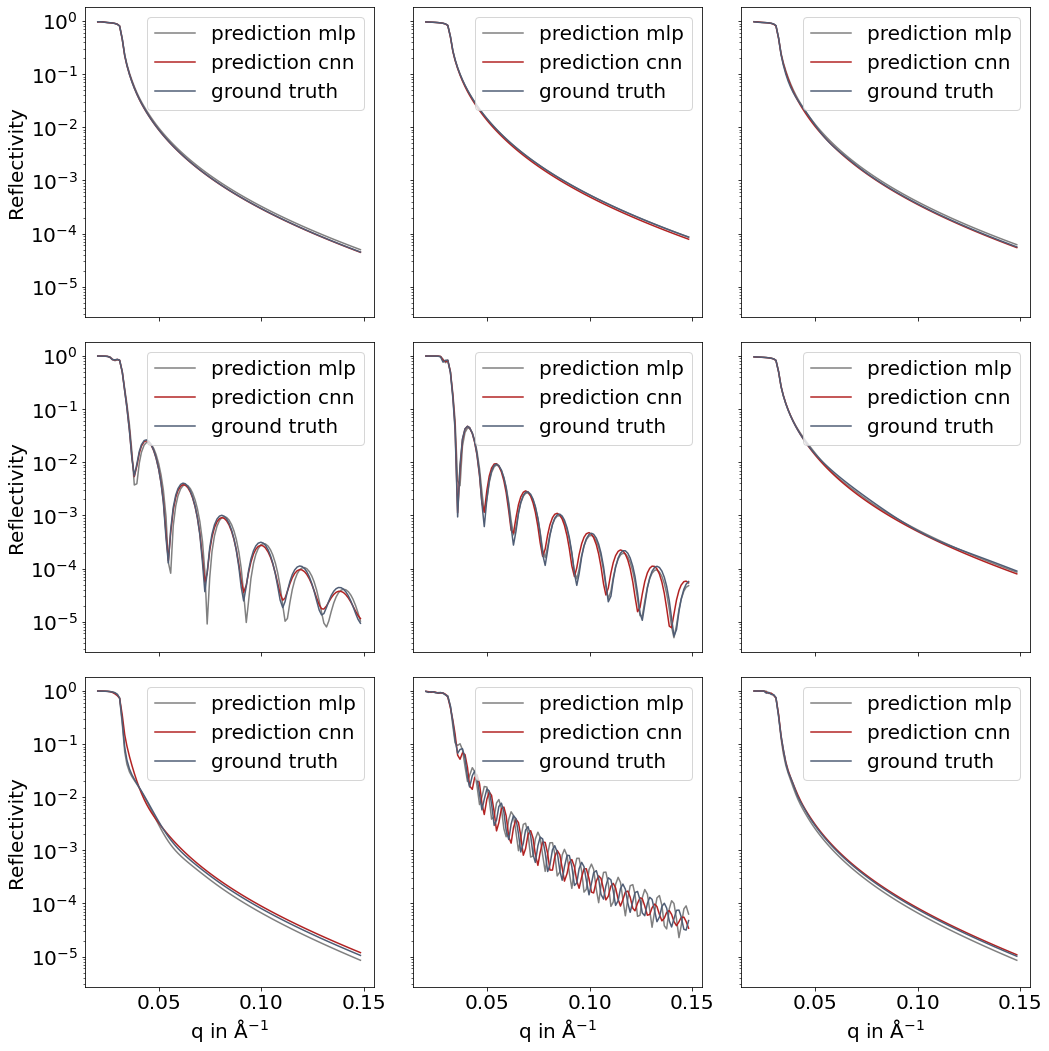

In [11]:
plots.gen_curves_plots(data_dict)


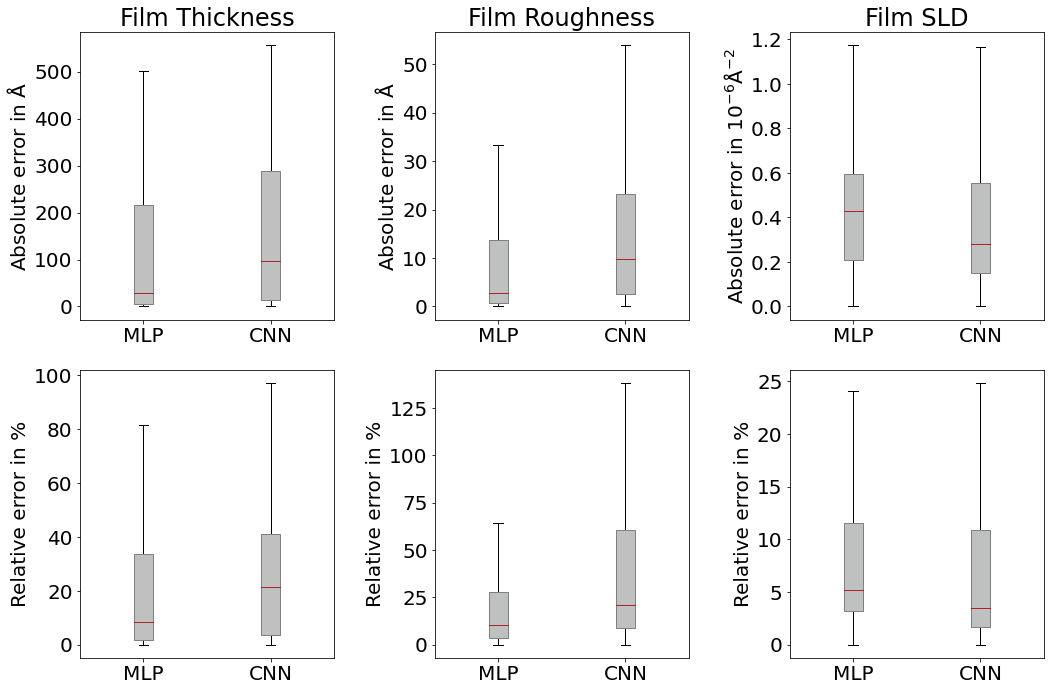

In [12]:
plots.gen_param_plots(error_dict_absolute_error, error_dict_relative_error)
